# Manifold learning techniques for time series forecasting

## Nikita Puchkin

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import normalize
from amd import AMD
from same_modified import SAME_plus
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.manifold import TSNE
from tqdm.notebook import tqdm
from statsmodels.tsa.arima_model import ARIMA

### Preprocessing

In [2]:
df = pd.read_excel('real_data.xls', names=['Время',\
'Реальные располагаемые денежные доходы в % к предущему месяцу',\
'Реальные располагаемые денежные доходы в % к соответствующему периоду предыдущего года',\
'Реальные располагаемые денежные доходы база январь 1999 =100',\
'Реальная начисленная заработная плата одного работника в % к предыдущему месяцу',\
'Реальная начисленная заработная плата одного работника база январь 1999 =100'])
df = df.dropna()

In [3]:
data = np.array(df)[:, 1:]
data[55:60, 0] = [99.8, 101.0, 106.1, 100.1, 130.4]
data[55:60, 3] = [98.3, 100.9, 104.6, 101.1, 121.3]
data[61, 3] = 102.3
timestamps = np.arange(data.shape[0])

In [4]:
data = data[:, [1,2,4]]
print(data.shape)

(238, 3)


In [5]:
mask = np.tile(np.append(np.ones(1), np.append(np.zeros(10), np.ones(1))), 20)[:-2]
data = data[mask==0]
timestamps = timestamps[mask==0]

### Predictor

In [6]:
# parameters
bandwidth = 12

In [7]:
# Convert a time series to large-dimensional vectors
#
# ts -- 2-dimensional array, pepresenting a multivariate time series
# bandwidth -- size of the bandwidth
#
# returns: an array of large-dimensional vectors

def ts_to_vec(ts, bandwidth=8):
    
    vec = ts[:, :]
    for i in range(bandwidth-1):
        vec = np.append(vec[:-1, :ts.shape[1]], vec[1:, :], axis=1)
        
    return vec

In [8]:
def generalized_features(Y_train, bandwidth=12):
    
    # construct the generalized states
    Y_gen = ts_to_vec(Y_train, bandwidth=bandwidth)
    # split the generalized data onto new train and test features
    X_train = Y_gen[:-1, :]
    X_test = Y_gen[-1, :].reshape(-1)
    
    return X_train, X_test

In [9]:
# Localizing kernel for computation of weights
def loc_kernel(x):
    # Epanechnikov kernel
    return np.maximum(1 - x**2, 0)

In [10]:
def shifted_weighted_kNN(timestamps_train, timestamps_test, X_train, Y_train, X_test, n_neighbors, kernel=loc_kernel, lambd=0.05):
    
    # increments
    n_train = Y_train.shape[0]
    A = np.diag(np.ones(n_train), 0) - np.diag(np.ones(n_train-1), -1)
    A[0,0] = 0
    increments = A.dot(Y_train)
    Y_shifted = increments + Y_train[-1]
    
    # predictions
    Y_pred = np.empty(Y_train.shape[1])
    # compute distances
    dist = np.linalg.norm(X_train - X_test, axis=1)
    # sort distances
    sorted_dist = np.sort(dist)
    
    for i in range(Y_train.shape[1]):
        # compute weights
        h = sorted_dist[n_neighbors[i]]
        weights = kernel(dist / h)
        # reweight by the time
        weights = weights * np.exp(lambd * (timestamps_train - timestamps_test)) 

        # use weighted kNN for the prediction
        Y_pred[i] = np.sum(Y_shifted[:, i] * weights) / np.sum(weights)
    
    return Y_pred

In [11]:
def predict_AMD(timestamps_train, Y_train, timestamp_test, n_neighbors, bandwidth=12):
    
    # Construct the generalized features
    generalized_X_train, generalized_X_test = generalized_features(Y_train, bandwidth=bandwidth)
    
    # Construct a manifold
    generalized_X = np.append(generalized_X_train, generalized_X_test.reshape(1, -1), axis=0).astype(float)
    # Normalize the numerical features
    generalized_X = normalize(generalized_X)
    # Find a manifold
    Z = AMD(generalized_X, 25, lambd=3, n_iterations=3)
    
    # Define modified train and test features
    Z_train = Z[:-1, :]
    Z_test = Z[-1, :]
    
    predictions = shifted_weighted_kNN(timestamps_train[bandwidth:], timestamp_test,\
                                       Z_train, Y_train[bandwidth:], Z_test, n_neighbors=n_neighbors)
        
    return predictions

In [12]:
def predict_SAME(timestamps_train, Y_train, timestamp_test, n_neighbors, bandwidth=12):
    
    # Construct the generalized features
    generalized_X_train, generalized_X_test = generalized_features(Y_train, bandwidth=bandwidth)
    
    # Construct a manifold
    generalized_X = np.append(generalized_X_train, generalized_X_test.reshape(1, -1), axis=0).astype(float)
    # Normalize the numerical features
    generalized_X = normalize(generalized_X)
    # Find a manifold
    n_iterations = 10
    neighbors_list = np.array([50 * 0.93**i for i in range(n_iterations)]).astype(int)
    Z, covariances = SAME_plus(generalized_X, neighbors_list)
    
    # Define modified train and test features
    Z_train = Z[:-1, :]
    Z_test = Z[-1, :]
    
    predictions = shifted_weighted_kNN(timestamps_train[bandwidth:], timestamp_test,\
                                       Z_train, Y_train[bandwidth:], Z_test, n_neighbors=n_neighbors)
        
    return predictions

### Test

In [13]:
# Number of test months
n_test = 40
# number of months to predict ahead
lookfront = 1

In [14]:
n_neighbors_candidates = np.arange(3, 25, 3)

losses_amd  = np.empty((0, lookfront, 3))    
losses_same  = np.empty((0, lookfront, 3))

for nn in n_neighbors_candidates:

    predictions_amd  = np.empty((n_test, lookfront, 3))
    predictions_same  = np.empty((n_test, lookfront, 3))
    
    outcomes = np.empty((n_test, lookfront, 3))
    
    for i in tqdm(range(n_test)):
    
        Y_train_amd = data[:-n_test+i+1-lookfront, :]
        Y_train_same = data[:-n_test+i+1-lookfront, :]
        
        for k in range(lookfront):
            timestamps_train = timestamps[:-n_test+i+1-lookfront+k]
            timestamp_test = timestamps[-n_test+i+1-lookfront+k]
            Y_test = data[-n_test+i+1-lookfront+k, :]
            # Make predictions for the next month
            nn_arr = (nn*np.ones(3)).astype(int)
            predictions_amd[i, k, :] = predict_AMD(timestamps_train, Y_train_amd, timestamp_test, n_neighbors=nn_arr)[:]
            predictions_same[i, k, :] = predict_SAME(timestamps_train, Y_train_same, timestamp_test, n_neighbors=nn_arr)[:]
            
            outcomes[i, k, :] = Y_test[:]
            # Use the predictions as the training data
            Y_train_amd = np.append(Y_train_amd, predictions_amd[i, k, :].reshape(1,-1), axis=0)
            Y_train_same = np.append(Y_train_same, predictions_same[i, k, :].reshape(1,-1), axis=0)
            
    # Compute losses
    new_loss_amd = np.mean((predictions_amd-outcomes)**2, axis=0)
    new_loss_same = np.mean((predictions_same-outcomes)**2, axis=0)
    
    losses_amd = np.append(losses_amd, new_loss_amd.reshape(1, lookfront, 3), axis=0)
    losses_same = np.append(losses_same, new_loss_same.reshape(1, lookfront, 3), axis=0)
    
    print(nn, 'neighbors:', new_loss_amd)
    print(nn, 'neighbors:', new_loss_same)

  0%|          | 0/40 [00:00<?, ?it/s]

3 neighbors: [[ 15.25855211 557.87504788 455.46372847]]
3 neighbors: [[ 16.99648425 679.11332317 586.78313933]]


  0%|          | 0/40 [00:00<?, ?it/s]

6 neighbors: [[ 12.73012464 507.68180425 455.77096065]]
6 neighbors: [[ 13.37227526 525.95778034 513.75554684]]


  0%|          | 0/40 [00:00<?, ?it/s]

9 neighbors: [[ 11.38380111 511.41641554 422.63599954]]
9 neighbors: [[ 12.63079944 485.45190039 470.55886144]]


  0%|          | 0/40 [00:00<?, ?it/s]

12 neighbors: [[ 11.11492285 491.5377489  400.87208035]]
12 neighbors: [[ 12.43001313 459.76709791 431.57804213]]


  0%|          | 0/40 [00:00<?, ?it/s]

15 neighbors: [[ 10.71753065 473.55721341 393.68909354]]
15 neighbors: [[ 11.60178232 444.73385339 422.21601398]]


  0%|          | 0/40 [00:00<?, ?it/s]

18 neighbors: [[ 10.55471389 456.60872321 395.41513633]]
18 neighbors: [[ 11.39128842 442.29788425 410.7742843 ]]


  0%|          | 0/40 [00:00<?, ?it/s]

21 neighbors: [[ 10.70334005 448.79381446 392.32139809]]
21 neighbors: [[ 11.29227936 440.9618006  403.20867186]]


  0%|          | 0/40 [00:00<?, ?it/s]

24 neighbors: [[ 10.70164467 437.64026255 384.73341723]]
24 neighbors: [[ 11.14732892 438.46731254 401.99568834]]


In [15]:
n_cand = n_neighbors_candidates.shape[0]
models = ['AMD', 'SAME']
losses = {'AMD': losses_amd, 'SAME': losses_same}

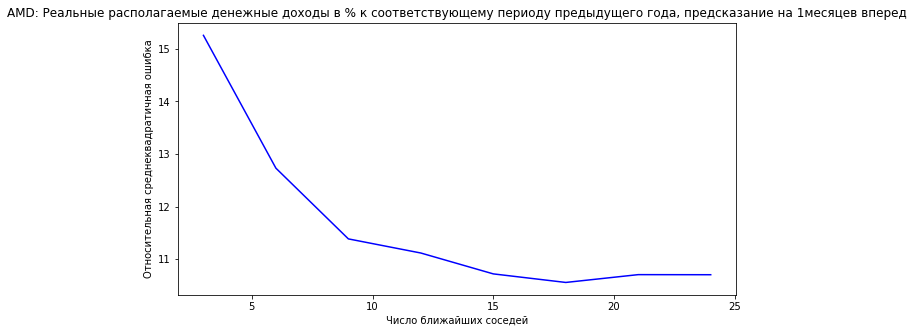

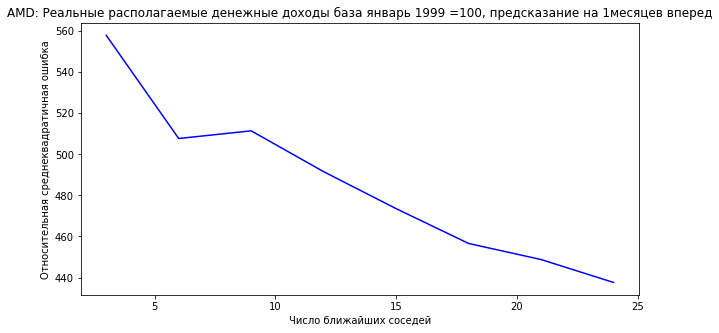

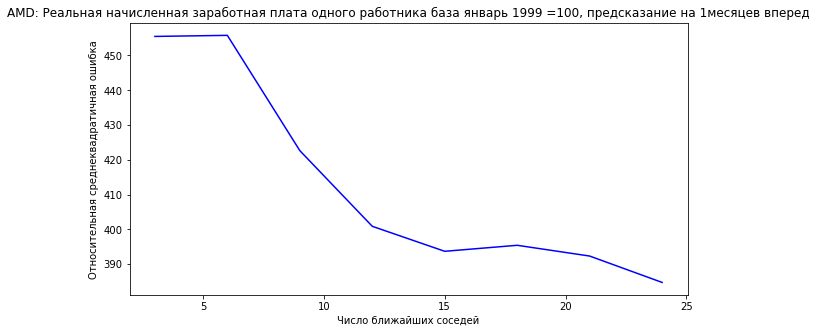

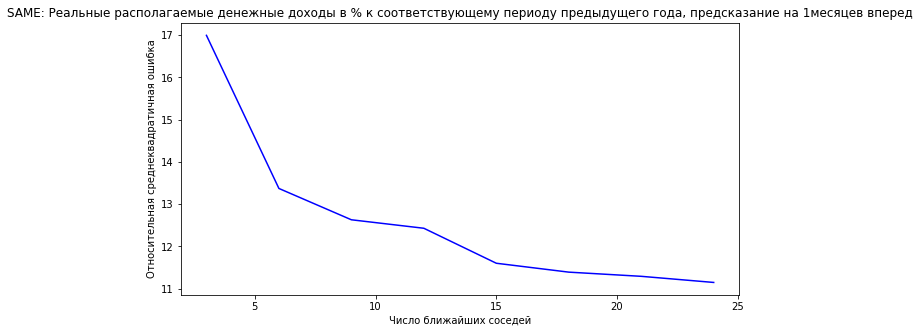

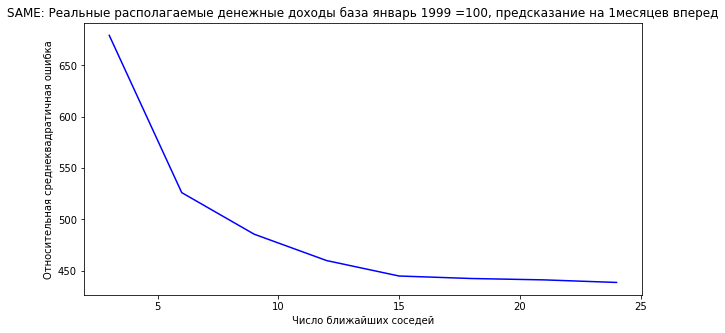

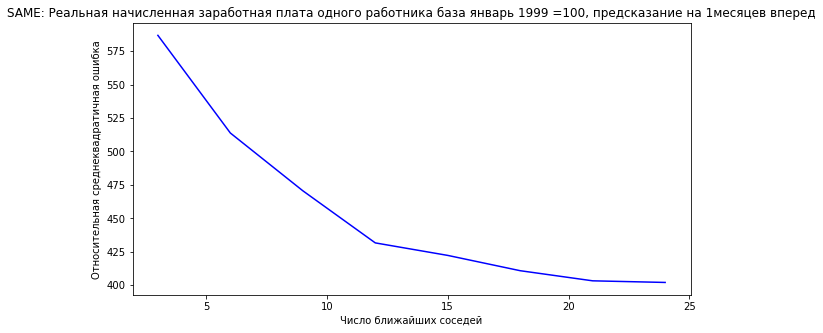

In [16]:
for i in range(lookfront):

    titles = ['Реальные располагаемые денежные доходы в % к соответствующему периоду предыдущего года, предсказание на '+str(i+1)+'месяцев вперед',\
              'Реальные располагаемые денежные доходы база январь 1999 =100, предсказание на '+str(i+1)+'месяцев вперед',\
              'Реальная начисленная заработная плата одного работника база январь 1999 =100, предсказание на '+str(i+1)+'месяцев вперед']

    
    for model in models:
        for j in range(3):

            fig = plt.figure(figsize=(10, 5))

            plt.plot(n_neighbors_candidates, losses[model][:, i, j], 'b-')
            plt.xlabel('Число ближайших соседей')
            plt.ylabel('Относительная среднеквадратичная ошибка')
            plt.title(model + ': ' + titles[j])
            plt.show()

In [17]:
nn_best = {}
for model in models:
    # determine the best number of neighbors
    nn_best[model] = n_neighbors_candidates[np.argmin(losses[model], axis=0)]
        
    print('Best number of neighbors for ' + model + ': ', nn_best[model])

Best number of neighbors for AMD:  [[18 24 24]]
Best number of neighbors for SAME:  [[24 24 24]]


  0%|          | 0/40 [00:00<?, ?it/s]

[18 24 24] AMD average loss: [10.554713885402629 437.64026254618886 384.7334172314341]
[24 24 24] SAME average loss: [11.147328915765321 438.4673125388085 401.9956883363326]


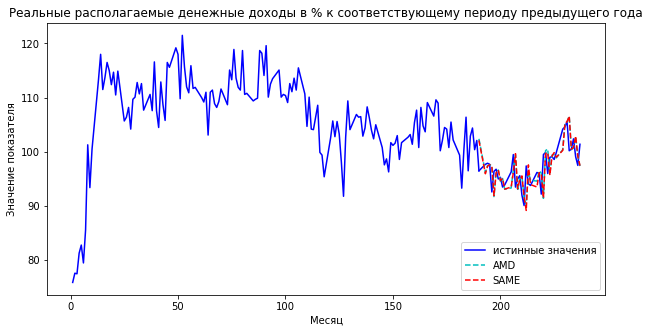

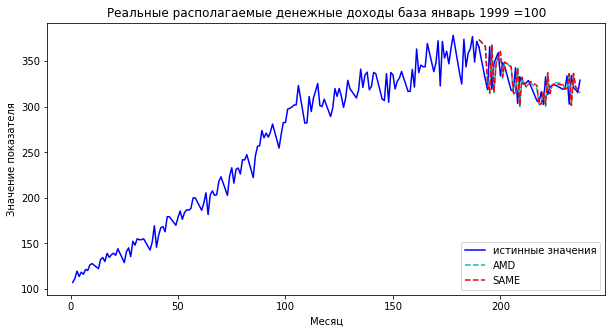

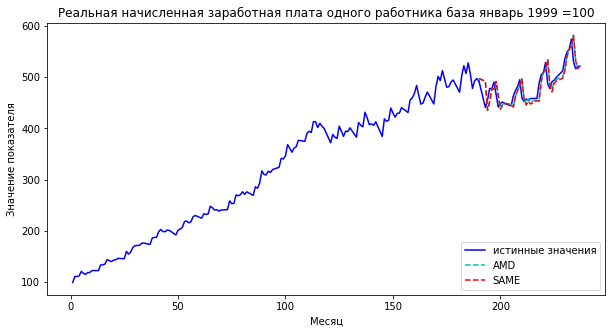

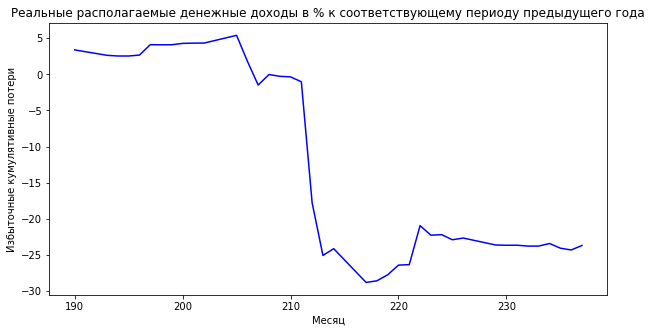

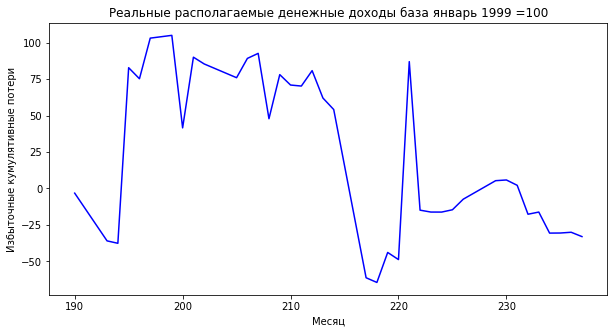

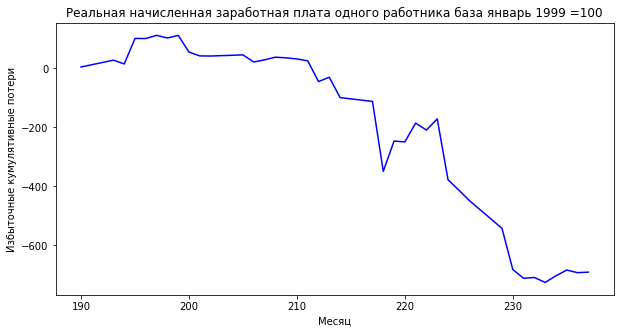

In [18]:
# predictions with the best number of neighbors

losses_amd = np.empty((0, n_test, 3))    
losses_same = np.empty((0, n_test, 3))
# number of months to predict ahead
for lookfront in [1]:

    # Initialization
    predictions_amd = np.empty((0, 3))
    predictions_same = np.empty((0, 3))
    predictions_knn = np.empty((0, 3))
    
    outcomes = np.empty((0, 3))
    
    nn_amd = nn_best['AMD'][lookfront-1]
    nn_same = nn_best['SAME'][lookfront-1]
    
    for i in tqdm(range(n_test)):
            
        Y_train_amd = data[:-n_test+i+1-lookfront, :]
        Y_train_same = data[:-n_test+i+1-lookfront, :]
        
        for k in range(lookfront):
            timestamps_train = timestamps[:-n_test+i+1-lookfront+k]
            timestamp_test = timestamps[-n_test+i+1-lookfront+k]
            Y_test = data[-n_test+i+1-lookfront+k, :]
            # Make predictions for the next month
            new_predictions_amd = predict_AMD(timestamps_train, Y_train_amd, timestamp_test, n_neighbors=nn_amd)
            new_predictions_same = predict_SAME(timestamps_train, Y_train_same, timestamp_test, n_neighbors=nn_same)
            # Use the predictions as the training data
            Y_train_amd  = np.append(Y_train_amd, new_predictions_amd.reshape(1,-1), axis=0)
            Y_train_same  = np.append(Y_train_same, new_predictions_same.reshape(1,-1), axis=0)
            
        predictions_amd = np.append(predictions_amd, new_predictions_amd.reshape(1,-1), axis=0)
        predictions_same = np.append(predictions_same, new_predictions_same.reshape(1,-1), axis=0)
        
        outcomes = np.append(outcomes, Y_test.reshape(1, -1), axis=0)
        
    new_loss_amd = (predictions_amd-outcomes)**2
    new_loss_same = (predictions_same-outcomes)**2
    
    losses_amd = np.append(losses_amd, new_loss_amd.reshape(1, n_test, 3), axis=0)
    losses_same = np.append(losses_same, new_loss_same.reshape(1, n_test, 3), axis=0)
    
    print(nn_amd, 'AMD average loss:', np.mean(new_loss_amd, axis=0))
    print(nn_same, 'SAME average loss:', np.mean(new_loss_same, axis=0))
    
    # Compute cumulative losses
    A = np.tril(np.ones((n_test, n_test)))
    new_cum_loss_amd = A.dot(new_loss_amd)
    new_cum_loss_same = A.dot(new_loss_same)
    
    # Plot the predicitons
    titles = ['Реальные располагаемые денежные доходы в % к соответствующему периоду предыдущего года',\
              'Реальные располагаемые денежные доходы база январь 1999 =100',\
              'Реальная начисленная заработная плата одного работника база январь 1999 =100']

    for i in range(3):

        T = data.shape[0]-n_test

        fig = plt.figure(figsize=(10, 5))

        plt.plot(timestamps[:T+1], data[:T+1, i], 'b-')
        plt.plot(timestamps[T: n_test + T], outcomes[:, i].reshape(-1), 'b-', label='истинные значения')
        plt.plot(timestamps[T: n_test + T], predictions_amd[:, i].reshape(-1), 'c--', label='AMD')
        plt.plot(timestamps[T: n_test + T], predictions_same[:, i].reshape(-1), 'r--', label='SAME')
        plt.legend(loc=4)
        plt.title(titles[i])
        plt.xlabel('Месяц')
        plt.ylabel('Значение показателя')
        plt.show()
                
    # Plot cumulative losses against the baseline
    titles = ['Реальные располагаемые денежные доходы в % к соответствующему периоду предыдущего года',\
              'Реальные располагаемые денежные доходы база январь 1999 =100',\
              'Реальная начисленная заработная плата одного работника база январь 1999 =100']

    for i in range(3):

        T = data.shape[0]-n_test

        fig = plt.figure(figsize=(10, 5))

        plt.plot(timestamps[T: n_test + T], new_cum_loss_amd[:, i].reshape(-1) - new_cum_loss_same[:, i].reshape(-1),\
                 'b-')
        plt.title(titles[i])
        plt.xlabel('Месяц')
        plt.ylabel('Избыточные кумулятивные потери')
        plt.show()